<a href="https://colab.research.google.com/github/hasanabbas21/spark-nlp/blob/main/CS777_Term_Project_Spark_NLP_Clinical_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import the Healthcare Licenses for Spark NLP Healthcare models 

***Natural Language Processing ***

1. NLP is domain specific.

2. Healthcare data is very unstructured

3. Clinical data from EMR, EHR
  - find presence of diseases, medications and treatment
  - selecting patients for clinical trials
  - de-identifying data (PHI/PII)

4. NER ( Named Entity recognition)
  - Classifier
  - run on a cluster (DL on Tendorflow)
  - building block for topic modeling, information retrieval, question answering- 

5. Spark NLP 
  - built on top of Spark ML
  - Spark NLP for healthcare clinical documents (enterprise version) , number one in adoption
  - Feature extraction from text 
  - Word embeddings
      - BERT
      - ELMO
      - GLOVE etc

6. Google Colab 
 - fully isolated runtime , all dependencies, run anytime , by anyone
 - open-jdk8
 - will run interactively ( except training and some steps that take minutes)
 - spark ML, spark NLP, spark JSL (Healthcare pack)
 - pipelines
 - Spark Dataframe

7. **PART -1**
  - Using pretrained models in Spark NLP
  - do some text entiry recognition using NER 

8. **PART -2**
  - Train our own models to classify clinical text:
    - identify adverse reaction to drugs/medications
  - Train on a deep learning model on Tensorflow
    - on top of spark ML
    - using **BioBERT** embeddings for tokens 
  - Save the trained model for later use
  - Load and perform inference on randon clinical text

9. Datasets
 - PART -1 
    - scraped from https://mtsamples.com
    - Medical Transcription Text
 - PART -2
    - open source dataset from Huggingface.com (an AI community)
    - https://huggingface.co/datasets/ade_corpus_v2




Get the **most** out of clinical text

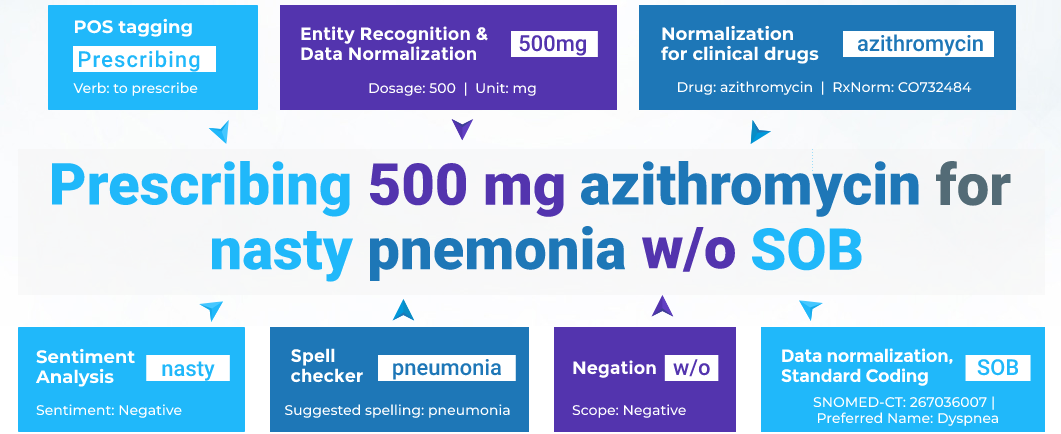

These are valid for only 1 month until 5/24.

You can register for a free 1 month trial here:

https://nlp.johnsnowlabs.com/docs/en/licensed_install

In [80]:
import json

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

Saving workshop_license_keys_365.json to workshop_license_keys_365.json


Check versions of Spark NLP Healthcare - spark jsl (John Snow Labs)

In [81]:
license_keys['JSL_VERSION']

'3.0.1'

In [82]:
# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

In [83]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

secret = license_keys['SECRET']

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)


Using the license keys install into colab runtime spark-nlp-jsl. The scripts are provided already by spark nlp getting started page and available in the JSL's github page

Also install spark nlp display library (spark-nlp-display) for visualizations for the results of the models on text (paragraph annotations)

In [6]:
%%capture
for k,v in license_keys.items(): 
    %set_env $k=$v

!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jsl_colab_setup.sh
!bash jsl_colab_setup.sh

! pip install spark-nlp-display

### Organize all the necessary imports, versions and session settings


We will use :
1. pyspark ML
2. sparknlp
3. sparknlp_jsl 

In [84]:
import json
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp

1. Initialize the spark-nlp-jsl session from the license keys 
2. Start the session with the configuration
3. verify the versions of spark nlp and spark jsl

In [85]:
params = {
    "spark.driver.memory":"16G",
    "spark.kryoserializer.buffer.max":"2000M",
    "spark.driver.maxResultSize":"2000M",
    "gpu":True
      }

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

Spark NLP Version : 3.0.1
Spark NLP_JSL Version : 3.0.1


### Setting up the Spark NLP Models in the pipeline

We will use pre-trained clinical models and run then on clinical text and observe the inferences first 
Then, we will train our own clinical model and run a test 
Three separate clinical use cases are explored in this project:


1.   **Named Entity Recognition** (problem, treatment and test classifier)
2.   **Posology** (medication strength, frequency, duration classifier)
3.   **Clinical Assertion** (presence of a problem)


We will use pipelines through out to chain the results of one clinical model after the other.


In order to train a Named Entity Recognition DL annotator, we need to get "CoNLL format" data as a "spark dataframe"
The text to process shoukld be in a column of the dataframe (e.g. **text** column in below assempler model)

ref: https://nlp.johnsnowlabs.com/docs/en/training


In [86]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")

Assembler converts data from the **text** column to **documents** for spark nlp to process.
ref: https://nlp.johnsnowlabs.com/docs/en/transformers#documentassembler-getting-data-in

In [10]:
sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
        .setInputCols(["document"])\
        .setOutputCol("sentence")

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[OK!]


ref: https://nlp.johnsnowlabs.com/docs/en/annotators#sentencedetector

Finds sentence bounds in raw text. Applies rules from Pragmatic Segmenter.


In [11]:
tokenizer = Tokenizer().setInputCols(["sentence"]).setOutputCol("token")

Tokenizer Identifies tokens with tokenization open standards.

ref: https://nlp.johnsnowlabs.com/docs/en/annotators#tokenizer

In [12]:
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical","en","clinical/models")\
        .setInputCols(["sentence","token"])\
        .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


WordEmbeddings model :
1. takes sentences and tokens in text and returns embeddings (vectors) for every word in the corpus
2. Trained on PubMed corpora https://www.nlm.nih.gov/databases/download/pubmed_medline.html
3. 4.5 Billion clinical words corpora

https://pubmed.ncbi.nlm.nih.gov/

In [13]:
medical_ner = MedicalNerModel.pretrained("ner_clinical_large","en","clinical/models")\
        .setInputCols(["sentence","token","embeddings"])\
        .setOutputCol("ner")

posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_clinical_large download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [14]:
posology_ner_greedy = MedicalNerModel.pretrained("ner_posology_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_greedy")

ner_posology_greedy download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [15]:
ner_converter = NerConverter()\
        .setInputCols(["sentence","token","ner"])\
        .setOutputCol("ner_chunk")

ner_converter_greedy = NerConverter()\
    .setInputCols(["sentence","token","ner_greedy"])\
    .setOutputCol("ner_chunk_greedy")

In [87]:
medical_ner.getClasses()

['O',
 'B-TREATMENT',
 'I-TREATMENT',
 'B-PROBLEM',
 'I-PROBLEM',
 'B-TEST',
 'I-TEST']

In [17]:
posology_ner.getClasses()

['O',
 'B-DOSAGE',
 'B-STRENGTH',
 'I-STRENGTH',
 'B-ROUTE',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'B-DRUG',
 'I-DRUG',
 'B-FORM',
 'I-DOSAGE',
 'B-DURATION',
 'I-DURATION',
 'I-FORM',
 'I-ROUTE']

**MedicalNerModel** is a pretrained model to recognize (NER's), Posology (dosages) as listed above from clinical text passed as input:

It takes word embeddings as **input** (I/P)
provides NER (Named Entity Recognition) tags as **Output**  O/P

Further, a **NERConverter** will chunk commonly occuring parts of sentences as chunks.




### Finally the pipeline is put together

Finally, the pipeline is constructed as a sequence of pretrained models . Each successive model taked output of previous step as input and passes the output to the next pretrained model

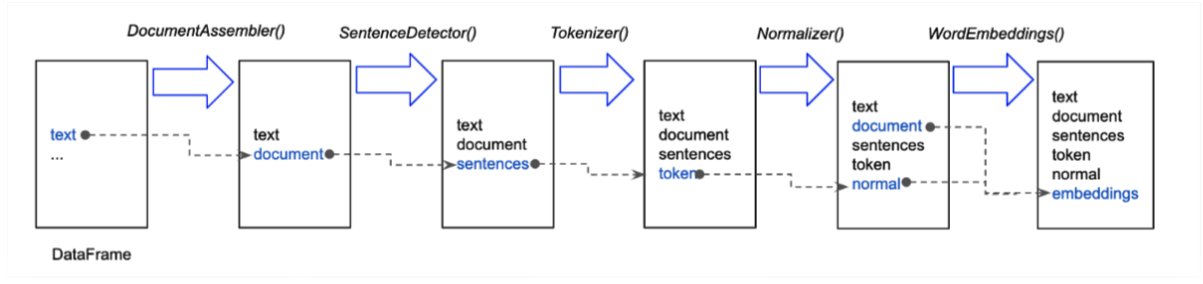

In [88]:
clinical_pipeline = Pipeline(stages=[
                          assembler,
                          sentenceDetector,
                          tokenizer,
                          word_embeddings,
                          medical_ner,
                          ner_converter])

In [19]:
nlp_df = spark.createDataFrame([[""]]).toDF("text")


As mentioned above, we need to have the data to train in the text column of a dataframe. Here since we are using a pretrained model, no need to train, just transform. Hence, use a dummy nlp_df and fit the pipeline

In [89]:
clinical_nlp_model = clinical_pipeline.fit(nlp_df)

In [21]:
clinical_nlp_model.stages

[DocumentAssembler_80c25e37f0b4,
 SentenceDetectorDLModel_d2546f0acfe2,
 REGEX_TOKENIZER_5314d583a740,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_1a8637089929,
 NerConverter_6eeb86110138]

The stages are exactly as described before

In [22]:
!wget -q https://storage.googleapis.com/mirza-cs777-bucket/term_project/mtsamples.csv

source : https://www.kaggle.com/tboyle10/medicaltranscriptions

I have saved a medical transcription data set into my google drive in public mode, we will retrieve it for today's work 

In [23]:
import pyspark.sql.functions as F

med_transcript_data = spark.read.option("header", "true").csv("mtsamples.csv")

In [24]:
med_transcript_data.show(2)

+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|         description|   medical_specialty|         sample_name|       transcription|            keywords|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0| A 23-year-old wh...| Allergy / Immuno...|  Allergic Rhinitis |SUBJECTIVE:,  Thi...|allergy / immunol...|
|  1| Consult for lapa...|          Bariatrics| Laparoscopic Gas...|PAST MEDICAL HIST...|bariatrics, lapar...|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [25]:
med_transcript_data.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- description: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- sample_name: string (nullable = true)
 |-- transcription: string (nullable = true)
 |-- keywords: string (nullable = true)



In [26]:
just_transcript = med_transcript_data.select("transcription")

In [27]:
just_transcript = just_transcript.withColumnRenamed("transcription","text")
just_transcript.show(n=5, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
pred = clinical_nlp_model.transform(just_transcript.limit(10))

ref: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

good article on **tf-idf vs word2vec vs BERT** is linked above.

In simple terms word embeddings are a probability distribution of each word appearing before or after another

**BERT** is the more advanced word vectorizer , where the position of the word in the sentence can give distinct vectors based on the context it appears. (Bank - institution vs Bank - river bank)








In [29]:
pred.show(2)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|SUBJECTIVE:,  Thi...|[{document, 0, 13...|[{document, 0, 80...|[{token, 0, 9, SU...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 71, 79, ...|
|PAST MEDICAL HIST...|[{document, 0, 24...|[{document, 0, 15...|[{token, 0, 3, PA...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 30, 55, ...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [30]:
pred.select(pred.embeddings.embeddings).show(n=5, truncate=150)

+------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                 embeddings.embeddings|
+------------------------------------------------------------------------------------------------------------------------------------------------------+
|[[0.0318841, 0.40408194, 0.054440014, 0.18353498, 0.19070132, 0.042645026, 0.35064465, 0.05275557, -0.098517776, -0.0938988, -0.0989423, -0.0915298...|
|[[0.019248715, 0.2662653, 0.04038137, 0.011361635, 0.08446897, 0.20159464, 0.31256086, -0.18080465, 0.07208785, -0.28536916, -0.23644105, -0.108261...|
|[[0.16081704, 0.15730344, 0.009294088, -0.3611929, -0.059181247, 0.024061408, 0.2844021, -0.2583885, 0.073464945, 0.055593852, -0.18373312, -0.0849...|
|[[-0.15749262, 0.112238824, 0.36661616, -0.14407827, -0.366398, -0.5085212, -0.23

In [31]:
pred.select('token.result','ner.result').show(truncate=150)

+------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                                result|                                                                                                                                                result|
+------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|[SUBJECTIVE, :,, This, 23-year-old, white, female, presents, with, complaint, of, aller

### Let's annotate using a light pipeline. text randonmly taken from the MT Dataset

In [32]:
text = '''
MGUS.  His bone marrow biopsy showed a normal cellular bone marrow; however, there were 10% plasma cells and we proceeded with the workup for a plasma cell dyscrasia.  All his tests came back as consistent with an MGUS.", Hematology - Oncology, MGUS Followup ,"CHIEF COMPLAINT: , MGUS.,HISTORY OF PRESENT ILLNESS:,  This is an extremely pleasant 86-year-old gentleman, who I follow for his MGUS.  I initially saw him for thrombocytopenia when his ANC was 1300.  A bone marrow biopsy was obtained.  Interestingly enough, at the time of his bone marrow biopsy, his hemoglobin was 13.0 and his white blood cell count was 6.5 with a platelet count of 484,000.  His bone marrow biopsy showed a normal cellular bone marrow; however, there were 10% plasma cells and we proceeded with the workup for a plasma cell dyscrasia.  All his tests came back as consistent with an MGUS.,Overall, he is doing well.  Since I last saw him, he tells me that he has had onset of atrial fibrillation.  He has now started going to the gym two times per week, and has lost over 10 pounds.  He has a good energy level and his ECOG performance status is 0.  He denies any fever, chills, or night sweats.  No lymphadenopathy.  No nausea or vomiting.  No change in bowel or bladder habits.,CURRENT MEDICATIONS: , Multivitamin q.d., aspirin one tablet q.d., Lupron q. three months, Flomax  0.4 mg q.d., and Warfarin 2.5 mg q.d.,ALLERGIES:  ,No known drug allergies.,REVIEW OF SYSTEMS: , As per the HPI, otherwise negative.,PAST MEDICAL HISTORY:,1.  He is status post left inguinal hernia repair.,2.  Prostate cancer diagnosed in December 2004, which was a Gleason 3+4.  He is now receiving Lupron.,SOCIAL HISTORY: , He has a very remote history of tobacco use.  He has one to two alcoholic drinks per day.  He is married.,FAMILY HISTORY: , His brother had prostate cancer.,PHYSICAL EXAM:,VIT:",
'''

In [33]:
clinical_nlp_model_light = LightPipeline(clinical_nlp_model)

pred_light = clinical_nlp_model_light.fullAnnotate(text)

Using spark_nlp_display we will annotate the results of the text processing done by the clinicalk pipeline

In [34]:
from sparknlp_display import NerVisualizer

vis = NerVisualizer()

vis.display(pred_light[0], label_col='ner_chunk', document_col='document')

### Now repeating ther same for a posology pipeline 

In [35]:
posology_pipeline = Pipeline(stages=[
                          assembler,
                          sentenceDetector,
                          tokenizer,
                          word_embeddings,
                          posology_ner,
                          posology_ner_greedy,
                          ner_converter,
                          ner_converter_greedy])

In [36]:
posology_nlp_model = posology_pipeline.fit(nlp_df)

In [37]:
posology_nlp_model_light = LightPipeline(posology_nlp_model)

posology_pred_light = posology_nlp_model_light.fullAnnotate(text)

In [90]:
vis = NerVisualizer()

vis.display(posology_pred_light[0], label_col='ner_chunk', document_col='document')

In [39]:
vis.display(posology_pred_light[0], label_col='ner_chunk_greedy', document_col='document')

### Classifier task on Adverse Drug Interactions using Spark-NLP, Neural Network Deel learning using Tensorflow


This new one has more than 25k

!pip install datasets

from datasets import load_dataset

dataset = load_dataset(

   'ade_corpus_v2', 'Ade_corpus_v2_classification')
   

In [40]:
!pip install datasets

from datasets import load_dataset

dataset = load_dataset(

'ade_corpus_v2', 'Ade_corpus_v2_classification')

     |████████████████████████████████| 225kB 5.3MB/s 
     |████████████████████████████████| 245kB 17.2MB/s 
     |████████████████████████████████| 112kB 21.6MB/s 


Dataset ade_corpus_v2 downloaded and prepared to /root/.cache/huggingface/datasets/ade_corpus_v2/Ade_corpus_v2_classification/1.0.0/940d61334dbfac6b01ac5d00286a2122608b8dc79706ee7e9206a1edb172c559. Subsequent calls will reuse this data.


In [41]:
cd /root/.cache/huggingface/datasets/ade_corpus_v2/Ade_corpus_v2_classification/1.0.0/

/root/.cache/huggingface/datasets/ade_corpus_v2/Ade_corpus_v2_classification/1.0.0


In [42]:
cd 940d61334dbfac6b01ac5d00286a2122608b8dc79706ee7e9206a1edb172c559

/root/.cache/huggingface/datasets/ade_corpus_v2/Ade_corpus_v2_classification/1.0.0/940d61334dbfac6b01ac5d00286a2122608b8dc79706ee7e9206a1edb172c559


In [43]:
ls -al

total 3340
drwxr-xr-x 2 root root    4096 May  1 17:37 ./
drwxr-xr-x 3 root root    4096 May  1 17:37 ../
-rw-r--r-- 1 root root 3404816 May  1 17:37 ade_corpus_v2-train.arrow
-rw-r--r-- 1 root root    3653 May  1 17:37 dataset_info.json
-rw-r--r-- 1 root root       0 May  1 17:37 LICENSE


In [44]:
dict_val = dataset.values()

In [45]:
import pandas as pd

text = []
label = []

for feats in dict_val:
    text = feats["text"]
    label = feats["label"]
    
dict = {'text':text,'label':label}
pd_df = pd.DataFrame(dict, columns=['text','label'])

print(text[1], " ", label[1])

Immobilization, while Paget's bone disease was present, and perhaps enhanced activation of dihydrotachysterol by rifampicin, could have led to increased calcium-release into the circulation.   1


In [46]:
pd.set_option('max_colwidth', 150)
pd_df

,text,label
0,Intravenous azithromycin-induced ototoxicity.,1
1,"Immobilization, while Paget's bone disease was present, and perhaps enhanced activation of dihydrotachysterol by rifampicin, could have led to inc...",1
2,Unaccountable severe hypercalcemia in a patient treated for hypoparathyroidism with dihydrotachysterol.,1
3,METHODS: We report two cases of pseudoporphyria caused by naproxen and oxaprozin.,1
4,METHODS: We report two cases of pseudoporphyria caused by naproxen and oxaprozin.,1
...,...,...
23511,"At autopsy, the liver was found to be small, shrunken, and scarred; histological sections demonstrated postnecrotic cirrhosis.",0
23512,"Physical exam revealed a patient with aphasia, tremor, and an expressionless face, able to make eye contact and move all four extremities.",0
23513,"At the time when the leukemia appeared seven of the patients were in complete, and one in partial, remission as regards the ovarian carcinoma.",0
23514,The American Society for Regional Anesthesia and Pain Medicine has specific guidelines for treatment of these patients when they undergo neuraxial...,0


Count number of cases of positive or negative for ADR

In [47]:
pd_df.label.value_counts()

0    16695
1     6821
Name: label, dtype: int64

Convert to **Spark** dataframe

In [48]:
from pyspark.sql.functions import *
spark_df = spark.createDataFrame(pd_df)
spark_df = spark_df.withColumn("label", col("label").cast(StringType()))
spark_df.show(4, truncate=100)

+----------------------------------------------------------------------------------------------------+-----+
|                                                                                                text|label|
+----------------------------------------------------------------------------------------------------+-----+
|                                                       Intravenous azithromycin-induced ototoxicity.|    1|
|Immobilization, while Paget's bone disease was present, and perhaps enhanced activation of dihydr...|    1|
|Unaccountable severe hypercalcemia in a patient treated for hypoparathyroidism with dihydrotachys...|    1|
|                   METHODS: We report two cases of pseudoporphyria caused by naproxen and oxaprozin.|    1|
+----------------------------------------------------------------------------------------------------+-----+
only showing top 4 rows



Make sure it matches the pandas dataframe value_counts .

In [49]:
spark_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|16695|
|    1| 6821|
+-----+-----+



In [50]:
spark_df.columns

['text', 'label']

In [51]:
spark_df.printSchema

<bound method DataFrame.printSchema of DataFrame[text: string, label: string]>

In [52]:
from pyspark.sql.functions import rand 

spark_df = spark_df.orderBy(rand()).limit(10000)
spark_df.count()

10000

In [53]:
from pyspark.sql.functions import *

spark_df = spark_df.withColumn('label', regexp_replace('label', "1", 'ADR'))
spark_df = spark_df.withColumn('label', regexp_replace('label', "0", 'NEG'))

spark_df.filter(spark_df.label == "ADR").show(4)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|DATA SYNTHESIS: G...|  ADR|
|Infants are parti...|  ADR|
|Symptoms and sign...|  ADR|
|OBJECTIVE: To rep...|  ADR|
+--------------------+-----+
only showing top 4 rows



In [54]:
spark_df.filter(spark_df.label == "NEG").show(4)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|Normal pregnancy ...|  NEG|
|In both our cases...|  NEG|
|Subsequently, the...|  NEG|
|Inhaled drugs mus...|  NEG|
+--------------------+-----+
only showing top 4 rows



### Split into training and Test dataset. Create Pipeline

In [55]:
(train, test) = spark_df.randomSplit([0.7, 0.3], seed = 100)
train.filter(spark_df.label == "ADR").count()

2088

In [56]:
train.filter(spark_df.label == "NEG").count()

4945

Lets see how many we have in the dataset for each

In [91]:
print("Training data count: " + str(train.count()))
print("Test data count: " + str(test.count()))

Training data count: 7033
Test data count: 2967


Each Annotator in the pipeline adds a column to the dataframe as it passes the dataframe to the next stage

As in the pretained NER pipeline, we will leverage the same **assembler**, **sentence detector** and **tokenizer** .
But will add **BertEmbeddings** model to provide the word embedings from text.

**BertEmbeddings** encode words and sentences in fixed-length dense vectors to drastically improve the processing of textual data , this is core of **NLP**.

**BERT** is better then just **WordEmbeddings** as it considers the context and sequence of words in account rather than just average of words

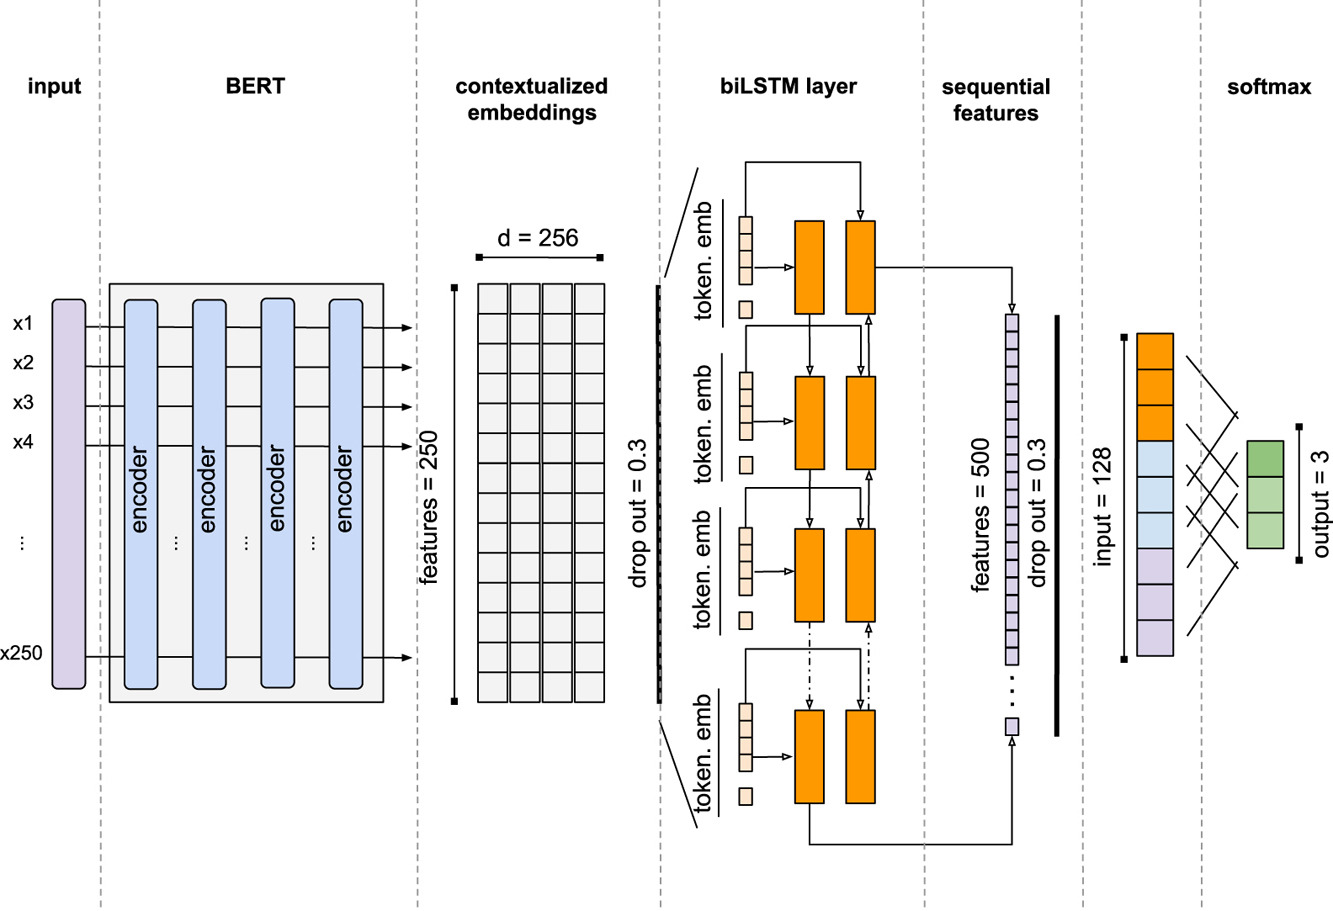

In [58]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
assembler = DocumentAssembler().setInputCol("text").setOutputCol("sentence")

In [59]:
tokenizer = Tokenizer().setInputCols(["sentence"]).setOutputCol("token")

In [60]:
bert_embeddings = BertEmbeddings.pretrained("biobert_pubmed_base_cased", "en", "public/models")\
                        .setInputCols(["sentence", "token"])\
                        .setOutputCol("embeddings")\

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]


**Pre-processing** is now **COMPLETE** - provide sentence embeddings to 
classifier

In [61]:
sentence_embeddings = SentenceEmbeddings()\
                      .setInputCols(["sentence", "embeddings"]) \
                      .setOutputCol("sentence_embeddings") \
                      .setPoolingStrategy("AVERAGE")

**ClassifierDL** is a multi-class text classifier that uses word embeddings as an input for text classifications. ClassifierDL annotator uses a deep learning model (DNNs) that is built inside **TensorFlow** and supports up to 50 classes

**(setLR, 0.0003)** the initial learning rate to start training

**(setMaxEpochs, 30)** how many iterations to train the deel neural network

**(setBatchSize, 8)** how many records to process in one epoch

ADR (Positive or negative)

**(sentence_embeddings)** final output of pre-processing pipeline

In [62]:
classifier_DNN = ClassifierDLApproach()\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("class")\
    .setLabelColumn("label")\
    .setBatchSize(8)\
    .setMaxEpochs(30)\
    .setLr(0.0003)\
    .setOutputLogsPath('./')\
    .setEnableOutputLogs(True)

In [63]:
bert_clf_pipe = Pipeline(
      stages = [
        assembler,
        tokenizer,
        bert_embeddings,
        sentence_embeddings,
        classifier_DNN
    ])

### Fit and train model 

Training completed in about 46 minutes for 30 epochs and batch size of 8

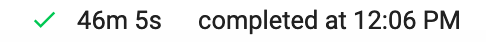

In [64]:
bert_clf_model = bert_clf_pipe.fit(train)


Now lets see how well the model trained

In [65]:
pred = bert_clf_model.transform(test)

pred.select('label','sentence',"class.result").show(10, truncate=100)

pred_pd = pred.select('label','sentence',"class.result").toPandas()

pred_pd['result'] = pred_pd['result'].apply(lambda x : x[0])

+-----+----------------------------------------------------------------------------------------------------+------+
|label|                                                                                            sentence|result|
+-----+----------------------------------------------------------------------------------------------------+------+
|  NEG|[{document, 0, 121, (2) In 8 out of 13 cases without recombinant human EPO treatment before PTX, ...| [NEG]|
|  NEG|[{document, 0, 121, 2 months later symptoms had resolved with a control CT of the thorax showing ...| [NEG]|
|  NEG|[{document, 0, 64, 2). These findings were characteristic of granular parakeratosis., {sentence -...| [NEG]|
|  NEG|[{document, 0, 97, 3 of the 5 previously untreated patients achieved biochemical and bone-marrow ...| [NEG]|
|  NEG|[{document, 0, 141, 3. Multiple myeloma and Hodgkin's disease, both of which commonly have good r...| [NEG]|
|  NEG|[{document, 0, 164, 5. At least half of the patients developing A

### Print out the Metrics and Classification Report for the test dataset

In [92]:
from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(pred_pd['result'], pred_pd['label']))

print(confusion_matrix(pred_pd['result'], pred_pd['label']))

              precision    recall  f1-score   support

         ADR       0.76      0.81      0.78       826
         NEG       0.93      0.90      0.91      2141

    accuracy                           0.88      2967
   macro avg       0.84      0.86      0.85      2967
weighted avg       0.88      0.88      0.88      2967

[[ 671  155]
 [ 214 1927]]


### Now save this model for future use and inferencing

In [67]:
bert_clf_model.stages[4].write().overwrite().save('models-1/ADR_DNN_Classifier_model')


Inference using our trained model. Need to load it just like a pretrained one and fit and transform.

In [68]:
adr_load_custom_cslf = ClassifierDLModel().load("models-1/ADR_DNN_Classifier_model")

In [69]:
from pyspark.sql.types import StructType,StructField, StringType
schema = StructType([
  StructField('text', StringType(), True),
  StructField('label', StringType(), True),
  ])

Need to create an empty dataframe to fit, as we dont want to train. It is already trained, ready to use


In [70]:
emptyRDD = spark.sparkContext.emptyRDD()
dummy_df = spark.createDataFrame(emptyRDD,schema)
dummy_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: string (nullable = true)



In [71]:
bert_clf_pipe = Pipeline(
      stages = [
        assembler,
        tokenizer,
        bert_embeddings,
        sentence_embeddings,
        adr_load_custom_cslf
    ])

In [72]:
adr_load_model = bert_clf_pipe.fit(dummy_df)


Now predict on the model we trained, saved and loaded

In [73]:
pred = adr_load_model.transform(test)

pred.select('label','sentence',"class.result").show(10, truncate=100)

pred_pd = pred.select('label','sentence',"class.result").toPandas()

pred_pd['result'] = pred_pd['result'].apply(lambda x : x[0])

+-----+----------------------------------------------------------------------------------------------------+------+
|label|                                                                                            sentence|result|
+-----+----------------------------------------------------------------------------------------------------+------+
|  NEG|[{document, 0, 121, (2) In 8 out of 13 cases without recombinant human EPO treatment before PTX, ...| [NEG]|
|  NEG|[{document, 0, 121, 2 months later symptoms had resolved with a control CT of the thorax showing ...| [NEG]|
|  NEG|[{document, 0, 64, 2). These findings were characteristic of granular parakeratosis., {sentence -...| [NEG]|
|  NEG|[{document, 0, 97, 3 of the 5 previously untreated patients achieved biochemical and bone-marrow ...| [NEG]|
|  NEG|[{document, 0, 141, 3. Multiple myeloma and Hodgkin's disease, both of which commonly have good r...| [NEG]|
|  NEG|[{document, 0, 164, 5. At least half of the patients developing A

In [93]:
from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(pred_pd['result'], pred_pd['label']))

print(confusion_matrix(pred_pd['result'], pred_pd['label']))

              precision    recall  f1-score   support

         ADR       0.76      0.81      0.78       826
         NEG       0.93      0.90      0.91      2141

    accuracy                           0.88      2967
   macro avg       0.84      0.86      0.85      2967
weighted avg       0.88      0.88      0.88      2967

[[ 671  155]
 [ 214 1927]]


### Individual text inference  (Single Sentences)

In [95]:
light_model = LightPipeline(adr_load_model)

result = light_model.fullAnnotate("A fatal massive pulmonary embolus developed in a patient treated with streptokinase for acute deep vein thrombosis")[0]
print( "The clinical statement is classified as - " ,result['class'][0].result)

The clinical statement is classified as -  NEG


In [76]:
light_model = LightPipeline(adr_load_model)

result = light_model.fullAnnotate("A young woman with epilepsy had tonic-clonic seizures during antineoplastic therapy with adriamycin and cisplatin.")[0]
print( "The clinical statement is classified as - " ,result['class'][0].result)

The clinical statement is classified as -  ADR


In [97]:
light_model = LightPipeline(adr_load_model)

result = light_model.fullAnnotate("Toxicity, pharmacokinetics, and in vitro hemodialysis clearance of ifosfamide and metabolites in an anephric pediatric patient with Wilms' tumor.")[0]
print( "The clinical statement is classified as - " ,result['class'][0].result)

The clinical statement is classified as -  ADR


In [94]:
light_model = LightPipeline(adr_load_model)

result = light_model.fullAnnotate("Hepatic reactions to cyclofenil.")[0]
print( "The clinical statement is classified as - " ,result['class'][0].result)

The clinical statement is classified as -  ADR


In [98]:
light_model = LightPipeline(adr_load_model)

result = light_model.fullAnnotate("onset of headache and naussea 10 minutes after talking allergy medicine claritin")[0]
print( "The clinical statement is classified as - " ,result['class'][0].result)

The clinical statement is classified as -  ADR
